We will be looking at credit card fraud detection in this notebook. The data is for two days worth of credit card transactions in September 2013 by european cardholders. It can be downloaded on Kaggle ([link to page with data file](https://www.kaggle.com/dalpozz/creditcardfraud)). The dataset is unbalanced - there are only 492 cases of fraud out of 284,807 transactions. So, oversampling methods (_ADASYN_ or _SMOTE_) can be very useful here to help with the imbalance issue.

Let's first import all the necessary packages:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from sklearn.metrics import roc_auc_score as auc, make_scorer
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [3]:
df = pd.read_csv('creditcard.csv')

You can see in the table below that there are 30 independent variables. The last column `Class` is the dependent variable that we're trying to predict (with value of 1 indicating fraud and 0 indicating no fraud). Columns `V1` - `V28` are principal components resulting from PCA dimensionality reduction of the original (28+n) variables. Unfortunately, due to confidentiality reasons, we do not know what those original variables were. We only get to see two of the original variables: `Amount`(the monetary amount of each transaction) and `Time`(seconds elapsed since first transaction in the data). For instance, the value of `Time` column of the last row is 172,792 seconds. That is equal to 48 hours(=172,792/60/60). As I mentioned above, the dataset contains two days of credit card transactions.

As it is, the `Time` variable won't be useful for prediction. It could maybe be useful if it indicated the time of day, however that's not the case here. Perhaps the time elapsed between each transaction for each individual card would've been useful, too. However, we cannot identify individual cards in this dataset, just transactions - we don't know which of the transactions came from the same card. 

The `Amount` variable will probably be useful, so we'll include it.

In [ ]:
print(df.head())
print(df.tail())


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We'll split the data into train and test sets. The training data will be used for model training purposes and, accordingly, the test set will be used to test how the final model performs on unseen data.

In [7]:
X_train, X_test, y_train, y_test = tts(df.drop(['Time', 'Class'], axis=1), df.Class, test_size=0.2,
                                       random_state=1)

In [5]:
vars = list(df)
for i in ['Time', 'Amount', 'Class']:
    vars.remove(i)

std_vars = StandardScaler().fit_transform(df[vars])
std_vars = pd.DataFrame(std_vars, columns=vars)
std_df = pd.concat([std_vars, df[['Time', 'Amount', 'Class']]], axis=1)
std_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Time,Amount,Class
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.0,149.62,0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,0.0,2.69,0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.0,378.66,0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,1.0,123.50,0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,2.0,69.99,0


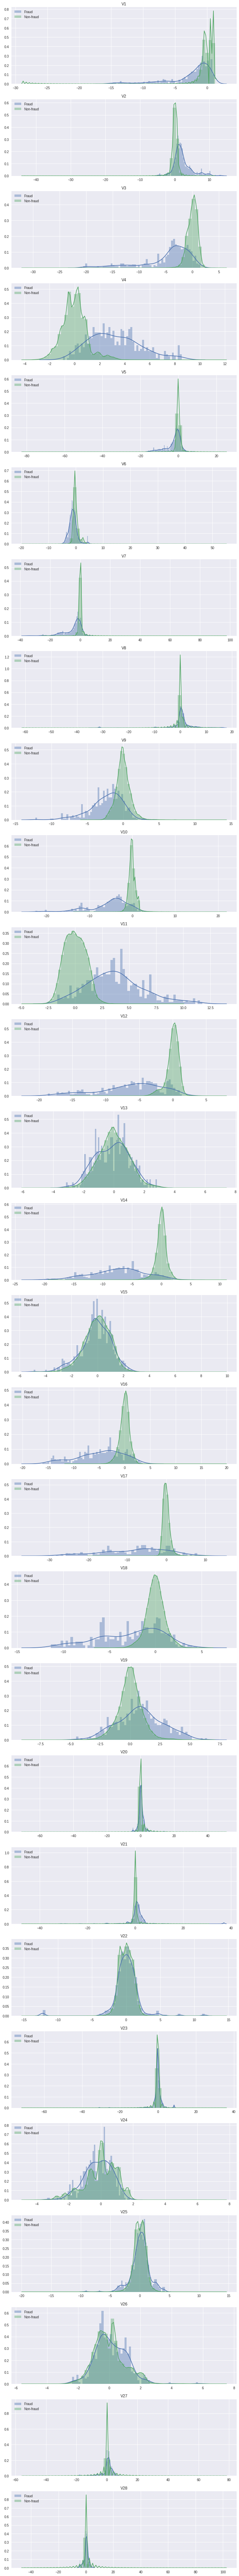

In [6]:
plt.figure(figsize=(12,140))
subplt = gridspec.GridSpec(len(vars), 1)
for i, j in enumerate(vars):
    ax = plt.subplot(subplt[i])
    sns.distplot(std_df[j][std_df.Class == 1], label='Fraud', bins=60)
    sns.distplot(std_df[j][std_df.Class == 0], label='Non-fraud', bins=60)
    ax.set_xlabel('')
    ax.set_title(j)
    plt.legend(loc='upper left')
plt.show()
plt.clf()

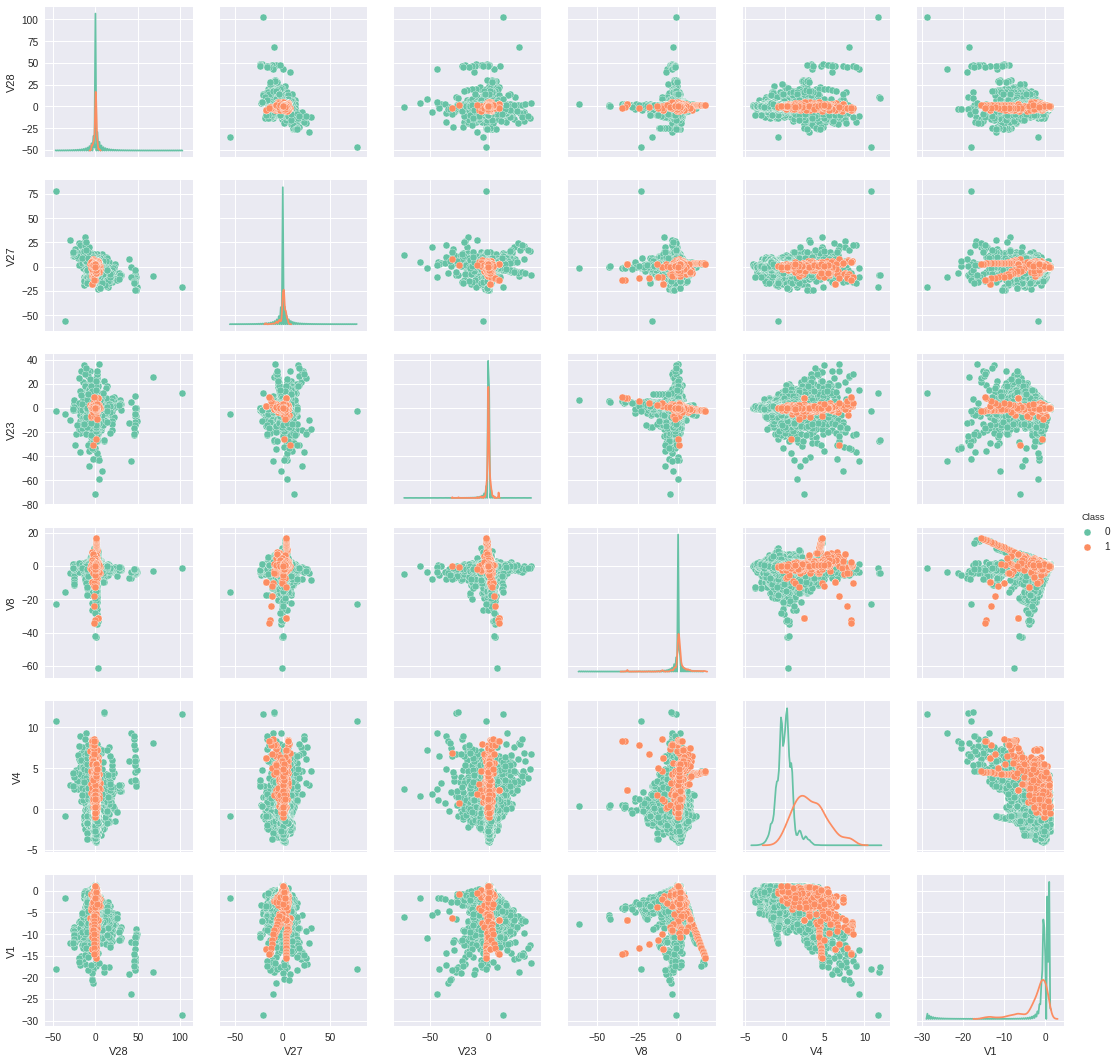

In [13]:

vars_sublist = ['V28', 'V27', 'V23', 'V8', 'V4', 'V1']
sns.pairplot(std_df, vars=vars_sublist, hue='Class', palette="Set2", diag_kind="kde", size=2.5)
plt.show()
plt.clf()

## Predictive Analysis

We'll try to fit a random forest model without any imbalance correction to see how the model would perform. The area under the ROC curve (AUC) will be used as the performance metric. We can use the nested crossvalidation function defined below:

In [8]:
def nested_CV_score(model, parameters, modelname, scorer=make_scorer(auc)):
    ''' Calculates the 5x3 nested cross validation score of a model with a given parameter grid
        Returns: nested_CV_scores (a list) and prints out their mean and standard deviation'''
    gs = GridSearchCV(model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=1)
    scores = cross_val_score(gs, X_train, y=y_train, scoring=scorer, cv=5, n_jobs=-1)
    print('5x3 Nested-CV AUC score for {}: {:.4f} +/- {:.4f}'\
          .format(modelname, np.mean(scores), np.std(scores)))
    return scores

In [9]:
forest = RandomForestClassifier(n_estimators=250, oob_score=1, n_jobs=-1,
                                warm_start=1, random_state=1)
param_grid = {'max_features': ['sqrt', 'log2', 0.1, 0.2]}
forest_AUC = nested_CV_score(forest, param_grid, 'Random Forest')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 38.3min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 38.6min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 38.6min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 38.6min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 38.9min finished


5x3 Nested-CV AUC score for Random Forest: 0.8913 +/- 0.0115


The AUC score from the nested cross-validation is __0.8913__ (0.8925 if we include the `Time` variable). Now, let's see if we can get a better score with oversampling the positive (fraud) class in the dependent variable using ADASYN:

In [10]:
adasyn = ADASYN(n_jobs=-1, random_state=1)
pipeline = imb_make_pipeline(adasyn, forest)
param_grid = {'randomforestclassifier__max_features': ['sqrt', 'log2', 0.1, 0.2]}
adasyn_forest_AUC = nested_CV_score(pipeline, param_grid, 'Random Forest')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 1258.4min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 1286.3min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 1293.9min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 1329.3min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 1335.0min finished


5x3 Nested-CV AUC score for Random Forest: 0.9184 +/- 0.0091


It took 22 hours and 15 minutes on my laptop for this ADASYN + Random Forest nested cross-validation to finish. As we can see, the AUC score improved to __0.9184__. Moreover, the standard deviation of the cross-validation scores decreased by almost 21% meaning that model performance is more stable. We can try and finetune the ADASYN step as well by varying the number of nearest neighbours used to construct synthetic samples(`n_neighbors` parameter). That would take even longer time, of course.

Now we use SMOTE instead of ADASYN for oversampling:

In [11]:
smote = SMOTE(random_state=1, kind='borderline2', n_jobs=-1)
pipeline = imb_make_pipeline(smote, forest)
param_grid = {'smote__kind': ['regular', 'borderline2', 'borderline2'],
              'randomforestclassifier__max_features': ['sqrt', 'log2', 0.1, 0.2]}
smote_forest_AUC = nested_CV_score(pipeline, param_grid, 'Random Forest')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 77.9min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 78.2min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 78.8min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 79.2min finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 79.3min finished


5x3 Nested-CV AUC score for Random Forest: 0.9135 +/- 0.0124


Using SMOTE results in slightly lower AUC score and less stable performance.

In [12]:
smote = SMOTE(random_state=1, n_jobs=-1)
pipeline = imb_make_pipeline(smote, forest)
param_grid = {'smote__kind': ['regular', 'borderline1', 'borderline2'],
              'randomforestclassifier__max_features': ['sqrt', 'log2', 0.1, 0.2]}
smote_forest_AUC = nested_CV_score(pipeline, param_grid, 'Random Forest')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/rustam/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 228.8min finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 229.2min finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 229.3min finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 231.6min finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 233.7min finished


5x3 Nested-CV AUC score for Random Forest: 0.9085 +/- 0.0119


## Tuning the best model

In [15]:
adasyn = ADASYN(n_jobs=-1, random_state=1)
forest = RandomForestClassifier(n_estimators=300, oob_score=1, n_jobs=-1,
                                warm_start=1, verbose=1, random_state=1)
pipeline = imb_make_pipeline(adasyn, forest)
param_grid = {'randomforestclassifier__max_features': ['sqrt', 'log2', 0.1, 0.2]}
forest_gs = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                         scoring=make_scorer(auc), cv=3, n_jobs=-1)
forest_gs.fit(X_train, y_train)

print("Best parameters: {}".format(forest_gs.best_params_))
print("Best cross-validation AUC score: {:.5f}".format(forest_gs.best_score_))
print("Test set AUC score: {:.5f}".format(forest_gs.score(X_test, y_test)))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.0min finished
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.4min finished
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  

Best parameters: {'randomforestclassifier__max_features': 'sqrt'}
Best cross-validation AUC score: 0.91719


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s


Test set AUC score: 0.89646


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.4s finished


In [ ]:
adasyn = ADASYN(n_jobs=-1, random_state=1)
pipeline = make_pipeline(adasyn, forest)

pipeline.fit(X_train, y_train)
y_pred_adasyn = pipeline.predict(X_train)

print(classification_report(y_train, y_pred_adasyn))
print(auc(y_train, y_pred_adasyn))